In [1]:
from tensorflow.python.eager import backprop
from tensorflow.python.keras.engine import data_adapter
from tensorflow.python.keras.mixed_precision.experimental import loss_scale_optimizer as lso
from tensorflow.python.distribute import parameter_server_strategy
import tensorflow as tf
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors
plt.style.use('seaborn-whitegrid')

In [2]:
###Get dataset
mnist_train = pd.read_csv('Data/digit-recognizer/train.csv').astype(np.float32)
mnist_test = pd.read_csv('Data/digit-recognizer/test.csv').astype(np.float32)

In [3]:
###Split dataset
y_train = mnist_train[['label']][:30000]
x_train = mnist_train[['pixel' + str(idx) for idx in range(784)]][:30000]

y_dev = mnist_train[['label']][30000:42000]
x_dev = mnist_train[['pixel' + str(idx) for idx in range(784)]][30000:42000]

x_test = mnist_test[['pixel' + str(idx) for idx in range(784)]]

In [4]:
###Rescale dataset
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_dev = scaler.transform(x_dev)
x_test = scaler.transform(x_test)

print(x_train.shape, y_train.shape, x_dev.shape, y_dev.shape, x_test.shape)

(30000, 784) (30000, 1) (12000, 784) (12000, 1) (28000, 784)


In [5]:
###Prepare for training: labels in sparse representation shape (-1)
ys = y_train.astype(int).values.reshape(-1)
xs = x_train
ys_one_hot = tf.one_hot(ys, 10)

ys_test = y_dev.astype(int).values.reshape(-1)
xs_test = x_dev

In [17]:
###Minimizer taken from tf library. Actually, this code is redundant and can be simplified
def _minimize(strategy, tape, optimizer, loss, trainable_variables):
    """Minimizes loss for one step by updating `trainable_variables`.
    This is roughly equivalent to
    ```python
    gradients = tape.gradient(loss, trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, trainable_variables))
    ```
    However, this function also applies gradient clipping and loss scaling if the
    optimizer is a LossScaleOptimizer.
    Args:
    strategy: `tf.distribute.Strategy`.
    tape: A gradient tape. The loss must have been computed under this tape.
    optimizer: The optimizer used to minimize the loss.
    loss: The loss tensor.
    trainable_variables: The variables that will be updated in order to minimize
    the loss.
    """

    with tape:
        if isinstance(optimizer, lso.LossScaleOptimizer):
            loss = optimizer.get_scaled_loss(loss)

    gradients = tape.gradient(loss, trainable_variables)

    # Whether to aggregate gradients outside of optimizer. This requires support
    # of the optimizer and doesn't work with ParameterServerStrategy and
    # CentralStroageStrategy.
    aggregate_grads_outside_optimizer = (
        optimizer._HAS_AGGREGATE_GRAD and  # pylint: disable=protected-access
        not isinstance(strategy.extended,
                       parameter_server_strategy.ParameterServerStrategyExtended))

    if aggregate_grads_outside_optimizer:
        # We aggregate gradients before unscaling them, in case a subclass of
        # LossScaleOptimizer all-reduces in fp16. All-reducing in fp16 can only be
        # done on scaled gradients, not unscaled gradients, for numeric stability.
        gradients = optimizer._aggregate_gradients(zip(gradients,  # pylint: disable=protected-access
                                                       trainable_variables))
    if isinstance(optimizer, lso.LossScaleOptimizer):
        gradients = optimizer.get_unscaled_gradients(gradients)
    gradients = optimizer._clip_gradients(gradients)  # pylint: disable=protected-access
    if trainable_variables:
        if aggregate_grads_outside_optimizer:
            optimizer.apply_gradients(
                zip(gradients, trainable_variables),
                experimental_aggregate_gradients=False)
        else:
            optimizer.apply_gradients(zip(gradients, trainable_variables))

###Model build in low level way
class Model(tf.keras.Model):
    def __init__(self, cl_coeff, dropout_rate = 0.1, variance_epsilon=1e-3, stddev = 0.1, bias = 0.1):
        super(Model, self).__init__()
        
        ###Model is Lenet++ taken from 'A Discriminative Feature Learning Approachfor Deep Face Recognition'
        
        #Input shape 28*28*1
        input_shape = (-1,28,28,1)
        
        ###Weights initialisation for convolution layers should be sqrt(2/k*k*c) as in Kaiming He's, 'Delving Deep into Rectifiers...')
        ###because using PReLU as activation function for Conv layers
        conv_init = tf.keras.initializers.he_normal()
        #conv_init = tf.random_normal_initializer(mean=0.0, stddev=stddev, seed=None)
        
        ###Biases initialisation for convolution layers. Should be zeroes.
        conv_bias_init = 'zeros'
        #conv_bias_init = tf.constant_initializer(bias)

        ###Model layers
        #1,2: (5/32)/1,2 x 2 PReLU
        #3: MaxPool 2/2,0
        #4,5: (5/64)/1,2 x 2 PReLU
        #6: MaxPool 2/2,0
        #7,8: (5/128)/1,2 x 2 PReLU
        #9: MaxPool 2/2,0 + Dropout
        #10: FC2 - feature vector
        #11: FC10 - output
        
        self.conv1_1 = tf.keras.layers.Conv2D(32, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init, input_shape=input_shape[1:])
        self.conv1_1_pr = self.get_conv_act(alpha=0.5)
        self.conv1_2 = tf.keras.layers.Conv2D(32, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init)
        self.conv1_2_pr = self.get_conv_act(alpha=0.5)
        self.pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='same')
        self.conv2_1 = tf.keras.layers.Conv2D(64, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init)
        self.conv2_1_pr = self.get_conv_act(alpha=0.3)
        self.conv2_2 = tf.keras.layers.Conv2D(64, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init)
        self.conv2_2_pr = self.get_conv_act(alpha=0.3)
        self.pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='same')
        
        ###For last two convolution layers added L1L2 regularizer
        self.conv3_1 = tf.keras.layers.Conv2D(128, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init, kernel_regularizer = self.get_regularizer(l1=0.01, l2=0.01))
        self.conv3_1_pr = self.get_conv_act(alpha=0.2)
        self.conv3_2 = tf.keras.layers.Conv2D(128, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init, kernel_regularizer = self.get_regularizer(l1=0.01, l2=0.01))
        self.conv3_2_pr = self.get_conv_act(alpha=0.2)
        self.pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='same')
        
        self.pool3_drop = tf.keras.layers.Dropout(dropout_rate)
        
        self.feat = tf.keras.layers.Dense(2, kernel_regularizer = self.get_regularizer(l1=0.01, l2=0.01))
        self.out = tf.keras.layers.Dense(10)
        
        ###Batch normalisation is not used
        #self.bn_conv1_2 = tf.keras.layers.BatchNormalization()
        #self.bn_conv2_2 = tf.keras.layers.BatchNormalization()
        #self.bn_conv3_2 = tf.keras.layers.BatchNormalization()
        #self.bn_feat = tf.keras.layers.BatchNormalization()
        #self.bn_out = tf.keras.layers.BatchNormalization()
        
        #Make centers tf.constants - because we update them manually
        self.centers = tf.constant(tf.zeros([10,2], dtype=tf.float32), name="centers")
        self.cl_coeff = cl_coeff
        self.dropout_rate = dropout_rate
        self.variance_epsilon = variance_epsilon
    
    def get_conv_act(self, alpha = 0.2):
        #return tf.keras.layers.LeakyReLU(alpha=alpha)
        return tf.keras.layers.PReLU(alpha_initializer = tf.constant_initializer(alpha))
    
    def get_regularizer(self,l1=0.01,l2=0.01):
        return tf.keras.regularizers.L1L2(l1=l1, l2=l2)
    
    #def get_features(self, x, training=False):
    def __call__(self, x, training=False):
        x_reshaped = tf.reshape(x, [-1,28,28,1])
        h_conv1_1 = self.conv1_1(x_reshaped)
        h_conv1_1_pr = self.conv1_1_pr(h_conv1_1)
        h_conv1_2 = self.conv1_2(h_conv1_1_pr)
        h_conv1_2_pr = self.conv1_2_pr(h_conv1_2)
        h_pool1 = self.pool1(h_conv1_2_pr)
        #h_pool1_bn = self.bn_conv1_2(h_pool1, training = training)
        
        tf.print(tf.nn.moments(h_conv1_2,axes=[0,1,2,3])[1])
        
        h_conv2_1 = self.conv2_1(h_pool1)
        h_conv2_1_pr = self.conv2_1_pr(h_conv2_1)
        h_conv2_2 = self.conv2_2(h_conv2_1_pr)
        h_conv2_2_pr = self.conv2_2_pr(h_conv2_2)
        h_pool2 = self.pool2(h_conv2_2_pr)
        #h_pool2_bn = self.bn_conv2_2(h_pool2, training = training)
        
        tf.print(tf.nn.moments(h_conv2_2,axes=[0,1,2,3])[1])
        
        h_conv3_1 = self.conv3_1(h_pool2)
        h_conv3_1_pr = self.conv3_1_pr(h_conv3_1)
        h_conv3_2 = self.conv3_2(h_conv3_1_pr)
        h_conv3_2_pr = self.conv3_2_pr(h_conv3_2)
        h_pool3 = self.pool3(h_conv3_2_pr)

        tf.print(tf.nn.moments(h_conv3_2,axes=[0,1,2,3])[1])
        
        h_pool3_flt = tf.reshape(h_pool3, [-1,h_pool3.shape[1]*h_pool3.shape[2]*h_pool3.shape[3]])  #tf.reshape(h_pool3, self.get_flat_shape(h_pool3))
        #h_pool3_bn = self.bn_conv3_2(h_pool3_flt, training = training)
        
        h_pool3_flt_drop = self.pool3_drop(h_pool3_flt,training = training)

        h_feat = self.feat(h_pool3_flt_drop)
        
        tf.print(tf.nn.moments(h_feat,axes=[0,1])[1])
        
        #features = self.bn_out(features, training = training)
        y_out = self.out(h_feat)
        
        #In case of library losses use softmax output
        return y_out, h_feat   #tf.nn.softmax(y_out)
    
    def get_center_loss(self, features, labels):
        labels = tf.reshape(labels, [-1])
        centers_batch = tf.gather(tf.stop_gradient(self.centers), labels)
        center_loss = tf.reduce_sum(input_tensor=(features - centers_batch) ** 2, axis=[1])
        return center_loss

    def centers_update(self, features, labels, alpha):
        labels = tf.reshape(labels, [-1])
        centers_batch = tf.gather(self.centers, labels)
        diff = centers_batch - features

        unique_label, unique_idx, unique_count = tf.unique_with_counts(labels)
        appear_times = tf.gather(unique_count, unique_idx)
        appear_times = tf.reshape(appear_times, [-1, 1])

        diff = diff / tf.cast((1 + appear_times), tf.float32)
        diff = alpha * diff
        
        label_reshaped = tf.reshape(labels,[-1,1])
        
        self.centers = tf.tensor_scatter_nd_sub(self.centers, label_reshaped, diff)
        
    def get_losses(self, x, y, training=False):
        y_pred, h_features = self(x, training=training)
        return self._get_losses(y, y_pred, h_features)

    def _get_losses(self, y, y_pred, h_features):
        y_one_hot = tf.one_hot(y, 10)
        center_loss = self.get_center_loss(h_features, y)
        softmax_loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf.stop_gradient(y_one_hot), logits=y_pred)
        loss = tf.reduce_mean(input_tensor=(softmax_loss + self.cl_coeff * center_loss)) # 
        return loss, softmax_loss, center_loss
    
    def get_accuracy(self, x, y):
        y_pred, _ = self(x, training=False)
        result = tf.argmax(input=y_pred,axis=1)
        ground_truth = tf.reshape(y, [-1])
        correct_prediction = tf.equal(result, ground_truth)
        accuracy = tf.reduce_mean(input_tensor=tf.cast(correct_prediction, tf.float32))
        return accuracy
    
    def get_centers(self):
        return self.centers
    
    def train_step(self, data):
        data = data_adapter.expand_1d(data)
        x, y, sample_weight = data_adapter.unpack_x_y_sample_weight(data)

        with backprop.GradientTape() as tape:
            y_pred, h_features = self(x, training=True)
            ###Calculate centerloss but don't include it in loss function
            loss, softmax_loss, center_loss = self._get_losses(y, y_pred, h_features) 
            #Default loss cant be used...
            #loss = self.compiled_loss(y, y_pred, sample_weight, regularization_losses=self.losses)
        
        ###Simple optimiser, not used.
        #trainable_variables = self.trainable_variables
        #gradients = tape.gradient(loss, trainable_variables)
        #self.optimizer.apply_gradients(zip(gradients, trainable_variables))
        _minimize(self.distribute_strategy, tape, self.optimizer, loss,
                  self.trainable_variables)
        
        ###Update center loss    
        self.centers_update(h_features, y, 0.5) 
        
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
        
        #trace output
        tf.print({m.name: m.result() for m in self.metrics})
        
        return {m.name: m.result() for m in self.metrics}
    
#Not used here, because can't implement center loss
class Softmax_and_center_loss(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        softmax_loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf.stop_gradient(y_true), logits=y_pred)
        loss = tf.reduce_mean(input_tensor=softmax_loss ) 
        return loss


In [18]:
###Train model with centerloss 0.05 dropout 0.15, batch size 256, 20 epochs (center loss needs more). Train/test accuracy = 0.99936664/0.97866666
model = Model(0.05, dropout_rate = 0.15, variance_epsilon=1e-3, stddev = 0.01, bias = 0.1)
model_loss = Softmax_and_center_loss()
opt = tf.keras.optimizers.Adam()#learning_rate=1e-4
bunch_len = 256
model.compile(opt, loss=model_loss, metrics=["accuracy"])

dataset = tf.data.Dataset.from_tensor_slices((xs, ys))
dataset_batches = dataset.batch(bunch_len)

for i in range(20):
    #loss, softmax_loss, center_loss = model.get_losses(xs, ys)
    #tf.print('Accuracy: ', model.get_accuracy(xs, ys))
    #tf.print('Full loss: ', loss)
    #tf.print('Softmax loss: ', softmax_loss)
    #tf.print('Center loss: ', tf.reduce_mean(center_loss))
    #tf.print('Centers: ', model.get_centers())
    for batch in dataset_batches:    
        model.train_step(batch)
print("====================================================")
print("Final train Accuracy:", model.get_accuracy(xs, ys))        
print("Final test Accuracy:", model.get_accuracy(xs_test, ys_test))     

1.70114982
3.39478135
4.57325
2.86750484
{'accuracy': 0.1171875}
1.51856315
2.9057374
7.03563404
324.368103
{'accuracy': 0.162109375}
1.48581958
1.73953867
1.29599512
5.47591209
{'accuracy': 0.166666672}
1.29897296
1.18676865
0.558765292
1.05987871
{'accuracy': 0.16015625}
1.18845868
1.00861704
0.39868027
1.93389988
{'accuracy': 0.16015625}
1.22597814
1.0465554
0.485901743
6.19621372
{'accuracy': 0.15625}
1.25342584
0.973573
0.495138764
6.07534933
{'accuracy': 0.154575899}
1.31636453
0.930656731
0.443761587
3.28736615
{'accuracy': 0.1484375}
1.04669046
0.788744926
0.351963788
1.07613099
{'accuracy': 0.151475698}
1.08831775
0.818923414
0.367846578
0.56069386
{'accuracy': 0.159375}
1.00913405
0.736985207
0.337777823
0.571494818
{'accuracy': 0.165482953}
2.0941627
1.49432492
0.760630608
1.09209239
{'accuracy': 0.162109375}
1.17596519
0.834570408
0.420670658
0.653289676
{'accuracy': 0.169771641}
1.37645507
1.01875389
0.523076296
0.975647449
{'accuracy': 0.177176341}
1.37999177
1.11122799
0

0.902872086
11.044754
{'accuracy': 0.364833325}
2.0249362
2.02143526
1.09283972
11.6086807
{'accuracy': 0.365943938}
2.06798482
2.00611567
1.02895498
12.9588203
{'accuracy': 0.367101461}
2.18391705
2.09871554
1.09358358
12.5505161
{'accuracy': 0.367882222}
2.0996139
2.01517749
1.06373429
12.6811981
{'accuracy': 0.368392199}
1.99092555
1.95344663
1.01066911
10.8582954
{'accuracy': 0.369277507}
2.03289938
1.98501682
1.0172708
11.0203037
{'accuracy': 0.369989842}
2.16845608
2.036659
1.03879809
11.2337141
{'accuracy': 0.370973825}
2.34826899
2.14638758
1.10122037
10.1199341
{'accuracy': 0.371224403}
1.85679889
1.86945379
0.967964768
12.2481098
{'accuracy': 0.371873438}
1.91253722
1.96028233
1.00838506
12.466156
{'accuracy': 0.373187959}
1.82043898
1.86419833
0.968262255
12.5877657
{'accuracy': 0.373781085}
3.32863784
2.73605466
1.40946186
11.3225241
{'accuracy': 0.374425501}
2.08979487
2.05107546
1.05668986
13.2273884
{'accuracy': 0.375810117}
2.32607508
2.12026858
1.08677208
12.6411457
{'

{'accuracy': 0.492633343}
2.51640868
3.06337595
1.72111201
22.0869293
{'accuracy': 0.49371016}
2.58954644
3.15240812
1.75681913
24.9241257
{'accuracy': 0.49487704}
2.70462036
3.21239614
1.80603552
23.4772034
{'accuracy': 0.495951831}
2.61902547
3.16439509
1.73956335
21.3279
{'accuracy': 0.497181445}
2.49950218
3.0900743
1.76369679
21.9586411
{'accuracy': 0.498449743}
2.52039552
3.04858327
1.75888157
26.3540039
{'accuracy': 0.49956122}
2.71038604
3.23374295
1.83204901
23.9321308
{'accuracy': 0.50072825}
2.92764974
3.43558478
2.00172114
23.0137329
{'accuracy': 0.501901746}
2.31737471
2.95453405
1.7386198
25.324749
{'accuracy': 0.502921164}
2.3845191
3.09493279
1.76602495
24.086586
{'accuracy': 0.504171968}
2.27885628
2.98596263
1.78088284
25.5128632
{'accuracy': 0.505333}
4.01627064
4.09558058
2.28189468
24.7142563
{'accuracy': 0.506326079}
2.60541
3.24488759
1.862059
23.1650467
{'accuracy': 0.507421672}
2.87855911
3.31933713
1.9075439
23.4470387
{'accuracy': 0.508477}
2.78341174
3.37319

2.94359159
4.13490248
2.33431077
35.4915161
{'accuracy': 0.602980793}
3.06313348
4.20259619
2.36933255
32.78619
{'accuracy': 0.603604794}
2.97928286
4.18702078
2.28886318
34.345047
{'accuracy': 0.604368091}
2.85261869
4.09461308
2.3163197
34.3761826
{'accuracy': 0.605083287}
2.84170818
3.94374704
2.26842165
38.5493317
{'accuracy': 0.605783522}
3.06897
4.20649958
2.37097335
35.931366
{'accuracy': 0.606469}
3.29564333
4.42940474
2.54469323
35.1799393
{'accuracy': 0.607161462}
2.60886455
3.81254506
2.24034142
36.3033485
{'accuracy': 0.607806802}
2.69163752
3.98853064
2.27114296
36.2987137
{'accuracy': 0.608578205}
2.56539464
3.82124829
2.23177099
37.9202347
{'accuracy': 0.60927}
4.45037
5.14312315
2.80971646
33.8013458
{'accuracy': 0.609861195}
2.92617488
4.09999752
2.2861836
37.4046478
{'accuracy': 0.610534906}
3.215801
4.1406436
2.27338219
34.6751938
{'accuracy': 0.611247659}
3.08247399
4.15235567
2.27403545
35.6046333
{'accuracy': 0.611849964}
3.57943034
4.40121317
2.39731479
38.103462

41.7790146
{'accuracy': 0.670069873}
3.24527788
4.95961094
2.79747224
43.020195
{'accuracy': 0.670561194}
3.11589146
4.86693573
2.84359169
42.7169342
{'accuracy': 0.670992732}
3.08833337
4.65704393
2.73534966
46.5112152
{'accuracy': 0.671488285}
3.34871078
5.00863838
2.87880659
44.6845856
{'accuracy': 0.671957135}
3.58105779
5.26787949
3.0623517
43.8605347
{'accuracy': 0.672464907}
2.83441162
4.55218267
2.73571467
44.9448547
{'accuracy': 0.672929764}
2.92480707
4.75868273
2.74903274
42.9320755
{'accuracy': 0.673490524}
2.78462434
4.58981466
2.69767737
47.5810471
{'accuracy': 0.673959434}
4.81017399
6.09803486
3.30109882
44.9087257
{'accuracy': 0.674345076}
3.15860701
4.85406923
2.79579449
41.0851822
{'accuracy': 0.674785912}
3.49523234
4.93594027
2.77265334
42.4824333
{'accuracy': 0.675265431}
3.35430598
4.9766326
2.79671502
47.4635925
{'accuracy': 0.675686359}
3.88427234
5.2158289
3.00335932
46.2920418
{'accuracy': 0.676129758}
3.04323125
4.63828754
2.80526352
43.7600136
{'accuracy': 

3.18234086
50.7649841
{'accuracy': 0.719673693}
3.33416033
5.56219435
3.2572422
48.1375275
{'accuracy': 0.720062137}
3.30146456
5.33577442
3.15375686
56.2583313
{'accuracy': 0.720455885}
3.57659173
5.72915459
3.3413291
51.1177635
{'accuracy': 0.720848262}
3.81206465
6.0101161
3.56091
50.2281952
{'accuracy': 0.721252501}
3.02443314
5.22726679
3.2385335
53.4751053
{'accuracy': 0.721629083}
3.12260747
5.45336151
3.26866984
51.5896759
{'accuracy': 0.722030699}
2.96096468
5.22190428
3.17196035
52.4714165
{'accuracy': 0.722378552}
5.12361717
6.87633514
3.83517051
52.6099396
{'accuracy': 0.722686052}
3.3597405
5.55739117
3.28697491
49.4337616
{'accuracy': 0.723025143}
3.71459579
5.651721
3.25314713
48.7872353
{'accuracy': 0.723421693}
3.55325484
5.67930746
3.24578977
53.9464912
{'accuracy': 0.723751962}
4.11558819
6.00538158
3.4822979
53.8737717
{'accuracy': 0.724081099}
3.20977592
5.28392506
3.23138118
51.3787079
{'accuracy': 0.724473953}
4.27697086
6.18529654
3.61135364
49.1558876
{'accurac

53.9124374
{'accuracy': 0.758997142}
3.50380564
5.9265213
3.52572918
66.8410797
{'accuracy': 0.759303927}
3.78875494
6.31579113
3.68770266
55.8593903
{'accuracy': 0.759620905}
4.04205179
6.65564346
3.88552833
58.6015434
{'accuracy': 0.759931445}
3.20457959
5.8037734
3.54918623
62.2173767
{'accuracy': 0.760213733}
3.30195713
6.00095081
3.57159424
57.4050064
{'accuracy': 0.760517061}
3.12894487
5.75748253
3.49630666
58.7999344
{'accuracy': 0.760819614}
5.44713497
7.57522249
4.11451912
60.0947266
{'accuracy': 0.761099458}
3.5635457
6.09179211
3.65034366
55.7298355
{'accuracy': 0.761373043}
3.96525407
6.1848774
3.61006808
55.7038574
{'accuracy': 0.761673152}
3.7934916
6.22694778
3.62715793
61.3400803
{'accuracy': 0.761956036}
4.40978098
6.574862
3.89352751
62.5343323
{'accuracy': 0.762211}
3.43607569
5.81027842
3.71954036
55.8624191
{'accuracy': 0.76250869}
4.59455252
6.8264184
4.16450834
57.140564
{'accuracy': 0.762789249}
3.76646447
6.04754782
3.77167749
63.155407
{'accuracy': 0.76310151

{'accuracy': 0.790205896}
3.98974323
6.84831619
4.23393106
67.5808716
{'accuracy': 0.790445328}
4.22888422
7.12463856
4.43636847
61.1401787
{'accuracy': 0.790684164}
3.36102867
6.27029085
4.10262632
67.557457
{'accuracy': 0.790903628}
3.46872973
6.53586626
4.11928415
65.4115753
{'accuracy': 0.791136622}
3.27165055
6.23413324
3.97524691
62.5056686
{'accuracy': 0.791378438}
5.72173405
8.18138695
4.67439032
67.1022186
{'accuracy': 0.791596293}
3.7132628
6.58032
4.10346651
60.5302773
{'accuracy': 0.791827619}
4.13574791
6.70331049
4.01322174
62.3209496
{'accuracy': 0.792067766}
3.94495511
6.7247858
3.95824146
67.706131
{'accuracy': 0.792288601}
4.57454205
7.0375433
4.16221619
63.4125748
{'accuracy': 0.792485595}
3.56764
6.29906559
4.02366686
67.378479
{'accuracy': 0.792719424}
4.75132561
7.29524612
4.43551
61.184288
{'accuracy': 0.792952716}
3.89834213
6.4836278
4.06995106
67.3867
{'accuracy': 0.793190122}
4.4316678
7.06914282
4.50846624
64.0872879
{'accuracy': 0.793413}
3.20753264
5.93211

4.39811945
7.4722476
4.50278854
66.6453705
{'accuracy': 0.814999521}
3.49272132
6.59331036
4.21329212
73.2888336
{'accuracy': 0.815174341}
3.60516286
6.85451937
4.24515915
68.1489258
{'accuracy': 0.815357}
3.40776896
6.59234142
4.10167027
69.8452225
{'accuracy': 0.815551698}
5.9729414
8.69111443
4.82152939
69.7053452
{'accuracy': 0.815737724}
3.87229848
6.98954201
4.28284502
66.5769119
{'accuracy': 0.81591928}
4.32101297
7.11106396
4.17583084
65.6258
{'accuracy': 0.816108584}
4.13165951
7.14482355
4.11591053
72.2074
{'accuracy': 0.81628114}
4.80530357
7.52426338
4.34575033
73.4329224
{'accuracy': 0.816445172}
3.73269153
6.60686636
4.18279076
64.8469
{'accuracy': 0.816633403}
5.01323605
7.84037209
4.67025185
69.5696411
{'accuracy': 0.816813052}
4.12330484
6.95435333
4.26519632
71.538
{'accuracy': 0.817000449}
4.69887924
7.58707523
4.74792862
68.909
{'accuracy': 0.817175269}
3.39740562
6.39035845
4.23367357
66.813
{'accuracy': 0.817353785}
4.50583363
7.44507647
4.48043728
71.0424
{'accur

{'accuracy': 0.834556222}
3.72831035
7.20804644
4.67385
68.0364
{'accuracy': 0.834700644}
3.52728891
6.97299814
4.50004196
74.6982193
{'accuracy': 0.83485204}
6.20873
9.15044403
5.21179724
73.9658127
{'accuracy': 0.835003197}
4.00202417
7.32794333
4.6179
68.8003082
{'accuracy': 0.835157752}
4.48121405
7.49593925
4.57247734
69.4009094
{'accuracy': 0.835308373}
4.28194237
7.5598259
4.4684329
76.997406
{'accuracy': 0.835455}
4.97857
7.89513588
4.76732635
73.8766327
{'accuracy': 0.835597754}
3.86927629
7.04268026
4.50025654
76.6768494
{'accuracy': 0.83574748}
5.16143751
8.12301
5.03847504
67.846283
{'accuracy': 0.835900605}
4.2518487
7.25606108
4.5815773
77.4820557
{'accuracy': 0.836046219}
4.834
7.82749844
4.99800682
72.2321167
{'accuracy': 0.836191475}
3.48179817
6.5706315
4.46867895
69.592392
{'accuracy': 0.836340129}
4.62815046
7.59779739
4.60408926
76.0549316
{'accuracy': 0.836488485}
3.71541405
6.88210917
4.30034399
77.5354919
{'accuracy': 0.836632967}
4.03531265
7.14178467
4.3887634

{'accuracy': 0.850698113}
6.41486073
9.66753864
5.33648348
76.599
{'accuracy': 0.850824237}
4.14304829
7.84895182
4.75364971
82.141037
{'accuracy': 0.850946844}
4.61423302
7.87038
4.59615946
67.5956268
{'accuracy': 0.851069212}
4.4222517
8.00142384
4.5557065
79.8335571
{'accuracy': 0.851191401}
5.15630388
8.41096306
4.77740955
83.9779358
{'accuracy': 0.851310134}
3.97486067
7.42701674
4.54130793
74.9376373
{'accuracy': 0.851431906}
5.32542133
8.69901752
5.09819174
77.1044617
{'accuracy': 0.851556778}
4.36895561
7.68200445
4.66020441
74.7597046
{'accuracy': 0.851681411}
5.00528622
8.44185
5.17217875
84.0155716
{'accuracy': 0.851796031}
3.58603287
6.99656105
4.55537176
71.1906
{'accuracy': 0.851913691}
4.77782965
8.08259
4.78514242
76.9459076
{'accuracy': 0.852027953}
3.84522533
7.40504074
4.47050238
85.4149323
{'accuracy': 0.852148473}
4.16503716
7.65792036
4.59293079
72.801651
{'accuracy': 0.852268875}
4.37528133
7.76020288
4.63583851
75.433
{'accuracy': 0.852382481}
4.01442909
7.49779

4.96786213
81.6176453
{'accuracy': 0.864037812}
4.72361565
8.15326786
4.73544
76.5993576
{'accuracy': 0.864142179}
4.49681854
8.10828495
4.62390232
74.0518265
{'accuracy': 0.864237368}
5.28657436
8.69074345
4.85284138
91.0939407
{'accuracy': 0.864329398}
4.05603838
7.5743165
4.59811974
77.7167206
{'accuracy': 0.864430308}
5.44077969
8.87511063
5.06097698
74.1764145
{'accuracy': 0.864534}
4.47483158
7.91501427
4.70878935
81.432106
{'accuracy': 0.864637613}
5.10787725
8.65103245
5.17237139
82.4764099
{'accuracy': 0.864735}
3.65442419
7.1274066
4.63079643
75.4138641
{'accuracy': 0.864838243}
4.87067223
8.26545906
4.93101645
76.9522705
{'accuracy': 0.864938378}
3.92081571
7.53046
4.68958473
88.7087708
{'accuracy': 0.865038335}
4.25439215
7.7994833
4.81978607
78.7734528
{'accuracy': 0.865138173}
4.46417284
7.86324215
4.90125322
74.3363342
{'accuracy': 0.865234852}
4.09885216
7.62189722
4.74875927
86.3231277
{'accuracy': 0.865337312}
4.07416821
7.41884375
4.5393672
83.3232117
{'accuracy': 0.

4.54432392
8.12705517
4.66784191
75.8951569
{'accuracy': 0.87521714}
5.34886026
8.74447346
4.8845253
91.2024536
{'accuracy': 0.875302136}
4.11105728
7.68221
4.62024879
86.9923096
{'accuracy': 0.875389755}
5.49161339
8.8141613
4.93805075
75.582695
{'accuracy': 0.875477254}
4.51472092
7.81180143
4.5218935
79.0440063
{'accuracy': 0.875564575}
5.18464518
8.64200401
5.0026269
92.4260254
{'accuracy': 0.875646353}
3.68269253
7.06933355
4.43993902
75.7313843
{'accuracy': 0.875733495}
4.90817833
8.12245
4.67917347
77.7566376
{'accuracy': 0.875820518}
3.94936538
7.48049116
4.46643257
89.7745819
{'accuracy': 0.87590462}
4.28708553
7.76209497
4.59738588
82.5981293
{'accuracy': 0.875986}
4.49189615
7.7713685
4.65535259
77.9998932
{'accuracy': 0.876069844}
4.11310148
7.5191021
4.52068615
83.8059082
{'accuracy': 0.876153648}
4.11684
7.41361284
4.44163322
88.6539612
{'accuracy': 0.876237333}
4.07044268
7.40583754
4.48283911
77.4181061
{'accuracy': 0.876320899}
5.04907942
8.18869209
4.80466032
83.13531

4.24326754
8.01839447
5.00480318
89.1661682
{'accuracy': 0.884745121}
5.65778065
9.19188118
5.29623032
79.6608429
{'accuracy': 0.884819865}
4.6456275
8.17507839
4.84729052
82.4967957
{'accuracy': 0.88489455}
5.3241148
9.00289822
5.20729208
90.6940689
{'accuracy': 0.884966612}
3.79083633
7.45380068
4.58818436
82.1735687
{'accuracy': 0.885038555}
5.04080248
8.53021336
4.76004
81.2345
{'accuracy': 0.885112941}
4.04541683
7.82240438
4.54517651
89.0873108
{'accuracy': 0.885182202}
4.4015336
8.21015072
4.68192101
85.4418793
{'accuracy': 0.885253847}
4.6207819
8.27741814
4.73991442
86.0533447
{'accuracy': 0.885325432}
4.21032143
7.91636801
4.60021734
83.9275894
{'accuracy': 0.885399461}
4.21721125
7.82313
4.55472851
89.1712723
{'accuracy': 0.885473371}
4.18015862
7.86766815
4.64561224
86.9871597
{'accuracy': 0.885547161}
5.15089369
8.54655266
4.94660044
84.5006561
{'accuracy': 0.885620892}
5.58473349
9.01742458
5.04401
87.2870483
{'accuracy': 0.885689497}
3.66545272
7.26045513
4.5574379
87.58

83.3110657
{'accuracy': 0.892875314}
4.64466858
8.35495663
5.05014753
84.101265
{'accuracy': 0.892939866}
5.33526659
9.17273808
5.38707876
92.5551605
{'accuracy': 0.893002}
3.79088044
7.61758375
4.74863672
89.7057495
{'accuracy': 0.893066347}
5.03471851
8.56514931
4.93369532
80.08
{'accuracy': 0.893128335}
4.04389858
7.88052559
4.67159081
91.2444534
{'accuracy': 0.893190205}
4.41223288
8.25128
4.80190182
91.9124
{'accuracy': 0.893252075}
4.61548424
8.19445515
4.78589725
82.3683929
{'accuracy': 0.89331615}
4.21636391
7.9324708
4.65294933
88.5813751
{'accuracy': 0.893380165}
4.22792
7.81768036
4.51837635
92.4283
{'accuracy': 0.893444061}
4.18141508
7.80892754
4.5522933
85.2604675
{'accuracy': 0.893507957}
5.18068504
8.54113483
4.76618576
88.5670166
{'accuracy': 0.893571734}
5.6203
9.00326
4.99466181
89.6542892
{'accuracy': 0.893635452}
3.66913223
7.32254696
4.44243097
87.4824219
{'accuracy': 0.89369905}
6.29643154
9.12539577
5.01675797
86.8193359
{'accuracy': 0.893762589}
4.06415224
7.54

5.37921333
96.3202133
{'accuracy': 0.900004387}
3.78476143
7.59074974
4.72826767
92.0612488
{'accuracy': 0.900060594}
5.03893518
8.48221397
4.92280912
83.3547211
{'accuracy': 0.900116742}
4.0459137
7.8357048
4.67877102
96.9525604
{'accuracy': 0.900170684}
4.41221046
8.16474915
4.88559771
92.0810242
{'accuracy': 0.900224507}
4.64212704
8.13832855
4.80022144
87.7473297
{'accuracy': 0.900280476}
4.23740673
7.82248783
4.67214346
91.4673462
{'accuracy': 0.900336385}
4.258636
7.72397518
4.54740191
93.9966736
{'accuracy': 0.900392175}
4.21809
7.76490402
4.60188961
91.1152954
{'accuracy': 0.900447965}
5.22779703
8.45482635
4.84986973
88.3532486
{'accuracy': 0.900503695}
5.68942213
8.9444313
5.04194832
91.806
{'accuracy': 0.90055716}
3.71095514
7.30332
4.52637577
94.7217255
{'accuracy': 0.900612772}
6.36597872
9.02156
5.07850313
86.321167
{'accuracy': 0.900668263}
4.09907866
7.49813
4.51047421
90.6395493
{'accuracy': 0.900723755}
5.01447916
8.51769733
4.86606216
92.4423
{'accuracy': 0.900779128

99.2565765
{'accuracy': 0.906214952}
5.12272596
8.94813347
5.3411479
84.41539
{'accuracy': 0.906264424}
4.08665133
8.12524414
4.93052912
88.8929901
{'accuracy': 0.90631175}
4.48098612
8.64723682
5.14063931
102.184105
{'accuracy': 0.906359}
4.67163801
8.41362858
5.01951551
84.3761368
{'accuracy': 0.90640831}
4.25652838
8.05844402
4.81502342
88.2037354
{'accuracy': 0.906457543}
4.29852533
8.03241253
4.74256802
101.108086
{'accuracy': 0.906506717}
4.23435783
7.91471148
4.73780346
87.4230728
{'accuracy': 0.906555831}
5.26215792
8.66135788
4.99495
89.403656
{'accuracy': 0.906604946}
5.70614576
9.13756
5.10639477
94.3597488
{'accuracy': 0.906653941}
3.69567132
7.3694272
4.52143049
90.4350433
{'accuracy': 0.906702936}
6.36008739
9.12444
4.98542404
92.1509705
{'accuracy': 0.906749785}
4.07925892
7.43426275
4.37095594
86.6607513
{'accuracy': 0.906798661}
4.99560595
8.44790554
4.70126295
91.951416
{'accuracy': 0.906847477}
3.92361522
7.37713146
4.45687675
100.881317
{'accuracy': 0.906896293}
4.7

7.68123722
4.76823187
84.8595352
{'accuracy': 0.911726952}
4.45512342
8.23465252
4.95462418
95.5811386
{'accuracy': 0.911770761}
4.67250872
8.13460732
4.7812109
90.3079071
{'accuracy': 0.911814511}
4.22251654
7.64429712
4.55539227
82.0816193
{'accuracy': 0.911858201}
4.27066469
7.65348577
4.49786091
91.5832672
{'accuracy': 0.911901832}
4.24371099
7.73873472
4.61332655
97.6021118
{'accuracy': 0.911945462}
5.23792505
8.25587845
4.72150803
81.6893082
{'accuracy': 0.911987066}
5.71068192
8.82531071
4.94567633
85.4799042
{'accuracy': 0.912030578}
3.71324372
7.22397804
4.4345789
97.5945358
{'accuracy': 0.912074089}
6.37930298
8.86597633
4.75472069
84.0322647
{'accuracy': 0.912117541}
4.07422256
7.28691339
4.22177505
84.8097839
{'accuracy': 0.912160933}
4.98177195
8.29379749
4.5154953
91.581131
{'accuracy': 0.912204266}
3.89299917
7.21509647
4.26064825
94.5491486
{'accuracy': 0.912247598}
4.7556138
7.80792093
4.36067867
87.7917328
{'accuracy': 0.912290812}
3.84284568
7.26068354
4.30388641
89.

4.46506882
8.02965546
5.10924673
94.1599426
{'accuracy': 0.916591585}
4.68726587
8.0382
5.06632662
90.3440704
{'accuracy': 0.916630685}
4.23366785
7.59279203
4.83073139
83.7508545
{'accuracy': 0.916669726}
4.27265692
7.58210611
4.69265318
88.5942078
{'accuracy': 0.916708708}
4.24707079
7.73783541
4.84440327
95.4863586
{'accuracy': 0.916747689}
5.25863695
8.31280231
4.99145746
88.1134109
{'accuracy': 0.916784823}
5.70203781
8.79524422
5.08759594
82.9541702
{'accuracy': 0.916823685}
3.69349146
7.21273422
4.70050859
92.7275314
{'accuracy': 0.9168607}
6.39592123
9.06437683
5.21231222
89.9823456
{'accuracy': 0.916899562}
4.0707736
7.36319733
4.58552837
86.5316162
{'accuracy': 0.916938365}
4.96849728
8.32569695
4.89166117
85.1588898
{'accuracy': 0.916977108}
3.90724492
7.36769438
4.61124
99.9977
{'accuracy': 0.917015791}
4.77715683
7.87416935
4.65904617
87.4584808
{'accuracy': 0.917054474}
3.8570838
7.32828569
4.62250614
90.2854843
{'accuracy': 0.917093158}
3.93823934
7.20047474
4.46783304
8

4.93616724
94.1415329
{'accuracy': 0.920950711}
4.22995472
7.38394594
4.77121735
81.8441772
{'accuracy': 0.920985818}
4.26662731
7.40011644
4.69040871
86.9608688
{'accuracy': 0.921020865}
4.23430538
7.59533
4.86556959
93.8457794
{'accuracy': 0.921055913}
5.25976372
8.23326778
4.98522615
90.2707443
{'accuracy': 0.921090901}
5.67946577
8.65809822
5.12584496
82.3656616
{'accuracy': 0.92112416}
3.65552402
7.01201105
4.62951088
89.2910843
{'accuracy': 0.921159089}
6.36334229
8.81471729
5.09974241
93.358078
{'accuracy': 0.921194}
4.02366257
7.08434629
4.44421768
82.3836899
{'accuracy': 0.921228886}
4.91980886
8.05778313
4.82038355
86.7470627
{'accuracy': 0.921263695}
3.8518846
7.08678818
4.51187801
97.4227371
{'accuracy': 0.921298563}
4.71606493
7.60319614
4.52166605
89.5098419
{'accuracy': 0.921333313}
3.78202033
6.99380255
4.49066067
86.6028671
{'accuracy': 0.921368062}
3.86830235
6.92471743
4.36284208
82.2297058
{'accuracy': 0.921401083}
3.82009363
6.85420322
4.33942842
87.5166
{'accuracy

In [19]:
#Get predictions and features for test dataframe
y_pred_logits, features_tf = model(xs_test)
features = np.array(features_tf)
y_pred_label = np.array(tf.argmax(y_pred_logits, axis=1))

6.90565109
9.50655651
5.44084501
87.6324387


In [20]:
###Show centers coords
np.array(model.centers)

array([[ 10.604778  , -13.726234  ],
       [  7.2208104 ,  15.368538  ],
       [ -8.775189  ,  -8.32336   ],
       [  9.820932  ,  -2.081608  ],
       [ -6.7432804 ,  14.905565  ],
       [ 11.509688  ,   5.3536325 ],
       [  0.09660726, -12.52177   ],
       [-12.890128  ,  -1.0303648 ],
       [ -0.06448372,   2.6210887 ],
       [-11.394388  ,   7.1443663 ]], dtype=float32)

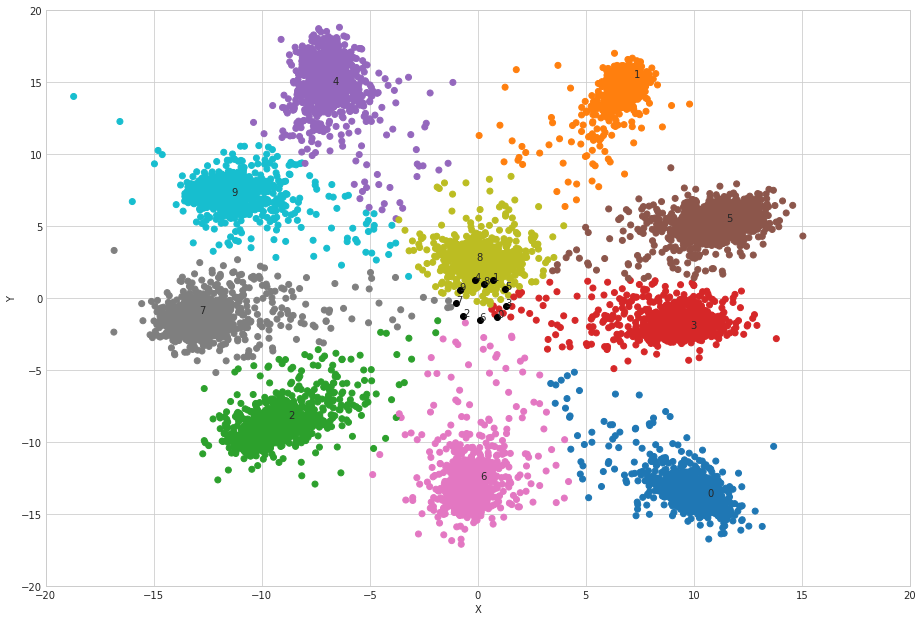

In [67]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)



class Plot_Report(object):
    def __init__(self, centers, class_vectors):
        self.fig = plt.figure()
        self.ax = self.fig.add_axes([-2,-2,2,2])
        self.centers = centers
        self.class_vectors = class_vectors
        self.center_names = ["0","1","2","3","4","5","6","7","8","9"]
        self.cmap = colors.ListedColormap(['#1f77b4', '#ff7f0e', 
                              '#2ca02c', '#d62728', 
                              '#9467bd', '#8c564b', 
                              '#e377c2', '#7f7f7f', 
                              '#bcbd22', '#17becf'])
        #self.cmap = discrete_cmap(10, 'cubehelix')
        
    def plot_data(self,x,y,c):
        self.ax.scatter(x,y, c=c , cmap=self.cmap, vmin=0, vmax=9) #, c=1 cmap=cmap
        
    def plot_centers(self):
        self.ax.scatter(self.centers[:,0],self.centers[:,1], c=[i for i in range(10)] , cmap=self.cmap, vmin=0, vmax=9) #, c=1 cmap=cmap
        for i, txt in enumerate(self.center_names):
            self.ax.annotate(txt, (self.centers[i,0], self.centers[i,1]))
        self.ax.set_xlabel('X')
        self.ax.set_ylabel('Y')
    def plot_class_vectors(self):
        self.ax.scatter(self.class_vectors[0],self.class_vectors[1], c="black")
        for i, txt in enumerate(self.center_names):
            self.ax.annotate(txt, (self.class_vectors[0,i], self.class_vectors[1,i]))
        self.ax.set_xlabel('X')
        self.ax.set_ylabel('Y')
        
    def show(self):
        plt.xlim(-20, 20)
        plt.ylim(-20, 20)
        plt.show()
        
myplot = Plot_Report(np.array(model.centers), model.out.weights[0].numpy())

myplot.plot_data(features[:,0],features[:,1],y_pred_label)
myplot.plot_centers()
myplot.plot_class_vectors()
myplot.show()

In [65]:
np.array(model.centers)

array([[ 10.604778  , -13.726234  ],
       [  7.2208104 ,  15.368538  ],
       [ -8.775189  ,  -8.32336   ],
       [  9.820932  ,  -2.081608  ],
       [ -6.7432804 ,  14.905565  ],
       [ 11.509688  ,   5.3536325 ],
       [  0.09660726, -12.52177   ],
       [-12.890128  ,  -1.0303648 ],
       [ -0.06448372,   2.6210887 ],
       [-11.394388  ,   7.1443663 ]], dtype=float32)

In [53]:
#Classification vectors
cv_x = model.out.weights[0].numpy()[0]
cv_y = model.out.weights[0].numpy()[0]

In [58]:
model.out.weights[0]

<tf.Variable 'dense_3/kernel:0' shape=(2, 10) dtype=float32, numpy=
array([[ 0.88432413,  0.68028337, -0.6672186 ,  1.2843869 , -0.15179698,
         1.276881  ,  0.08845953, -1.0143772 ,  0.2778069 , -0.8433039 ],
       [-1.3016163 ,  1.279158  , -1.2335091 , -0.55072093,  1.2718129 ,
         0.6290787 , -1.4957021 , -0.35204726,  0.9666587 ,  0.6032002 ]],
      dtype=float32)>